<a href="https://colab.research.google.com/github/Kryptera-K/IVV-Williams-Woodie-Reversal-Strategy/blob/main/IVV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "IVV"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("IVV_clean.csv", index=False)
df

/tmp/ipython-input-1944151441.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-05-19,89.122505,90.369666,88.845358,90.369666,775500
2000-05-22,88.568207,89.063112,86.667771,89.063112,1850600
2000-05-23,87.222046,88.825538,87.222046,88.825538,373900
2000-05-24,88.528564,88.726526,86.568742,87.261608,400300
2000-05-25,87.716995,89.280896,87.340867,88.706806,69600
...,...,...,...,...,...
2025-09-25,661.219971,662.580017,657.570007,661.140015,5037900
2025-09-26,664.890015,665.549988,661.090027,662.710022,4338500
2025-09-29,666.760010,668.429993,665.070007,667.570007,5026800


In [4]:
# -------------------------
# Necessary Parameters
# -------------------------

RSI_OVERBOUGHT_LEVEL = 70
RSI_OVERSOLD_LEVEL = 30
RSI_PERIOD = 14
RSI_SHIFT = 5
RSI_SHIFT_2 = 10
SR_LEVEL = 70
SR_PERIOD = 14
SR_X_BARS = 5
WOODIE_CCI_PERIOD = 14
WOODIE_FAST_PERIOD = 6
WOODIE_SHIFT = 5
WOODIE_SLOW_PERIOD = 34
WR_LEVEL = -50
WR_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------

# -------------------------
# SR Percent Rank Calculation Function
# -------------------------
def calculate_srpr(df, period=SR_PERIOD):
    def sr_percent_rank(series, period):
        """Internal Percent Rank Calculation"""
        return series.rolling(period).apply(
            lambda x: pd.Series(x).rank(pct=True).iloc[-1] * 100, raw=False
        )

    df['SRPR'] = sr_percent_rank(df['Close'], period)
    return df

def srpr_below_level(df, level=SR_LEVEL):
    df = calculate_srpr(df)
    return df['SRPR'] < level

def woodies_trend_down(df, period=WOODIE_SLOW_PERIOD):
    df['CCI_trend'] = calculate_woodie_cci(df, period)['CCI']
    return df['CCI_trend'] < 0


def calculate_woodie_cci(df, period=WOODIE_CCI_PERIOD):
    """
    Calculate Commodity Channel Index (CCI).
    """
    df = df.copy()
    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    # SMA of TP
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    # Mean Deviation
    df['MeanDev'] = df['TP'].rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    # CCI
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df


def rsi_change_upward(df, shift=RSI_SHIFT, shift2=RSI_SHIFT_2):
    df = calculate_rsi(df)
    df['RSI_Previous'] = df['RSI'].shift(shift)
    return (df['RSI'] > df['RSI_Previous']) & (df['RSI_Previous'] <= df['RSI_Previous'].shift(shift2))


def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df


def wr_lower_than_level(df, level=WR_LEVEL):
    df = calculate_williams_r(df)
    return df['Williams_%R'] < level


def calculate_williams_r(df, period=WR_PERIOD):
    highest_high = df['High'].rolling(window=period).max()
    lowest_low = df['Low'].rolling(window=period).min()
    df['Williams_%R'] = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)
    return df



# -------------------------
# Entry conditions
# -------------------------
df["SRPR_Below_Level"] = srpr_below_level(df)
df["Woodies_Trend_Down"] = woodies_trend_down(df)

# -------------------------
# Exit conditions
# -------------------------

df["RSI_Change_Upward"] = rsi_change_upward(df)
df["WR_is_Lower_Than_Level"] = wr_lower_than_level(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'SRPR_Below_Level',
    'Woodies_Trend_Down',
]
exit_conditions = [
    'RSI_Change_Upward',
    'WR_is_Lower_Than_Level',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                 2000-05-19 00:00:00
End                                   2025-10-01 00:00:00
Period                                 6380 days 00:00:00
Start Value                                      100000.0
End Value                                  1046603.648948
Total Return [%]                               946.603649
Benchmark Return [%]                           637.382382
Max Gross Exposure [%]                              100.0
Total Fees Paid                              27151.976395
Max Drawdown [%]                                 51.94201
Max Drawdown Duration                  1342 days 00:00:00
Total Trades                                           56
Total Closed Trades                                    55
Total Open Trades                                       1
Open Trade PnL                               153765.85394
Win Rate [%]                                    67.272727
Best Trade [%]                                  40.845342
Worst Trade [%

In [5]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-05-19 00:00:00
End                           2025-10-01 00:00:00
Period                         6380 days 00:00:00
Start Value                              100000.0
End Value                           737382.381563
Total Return [%]                       637.382382
Benchmark Return [%]                   637.382382
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                         55.40339
Max Drawdown Duration          1544 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      637382.381563
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-49781475.py:69: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


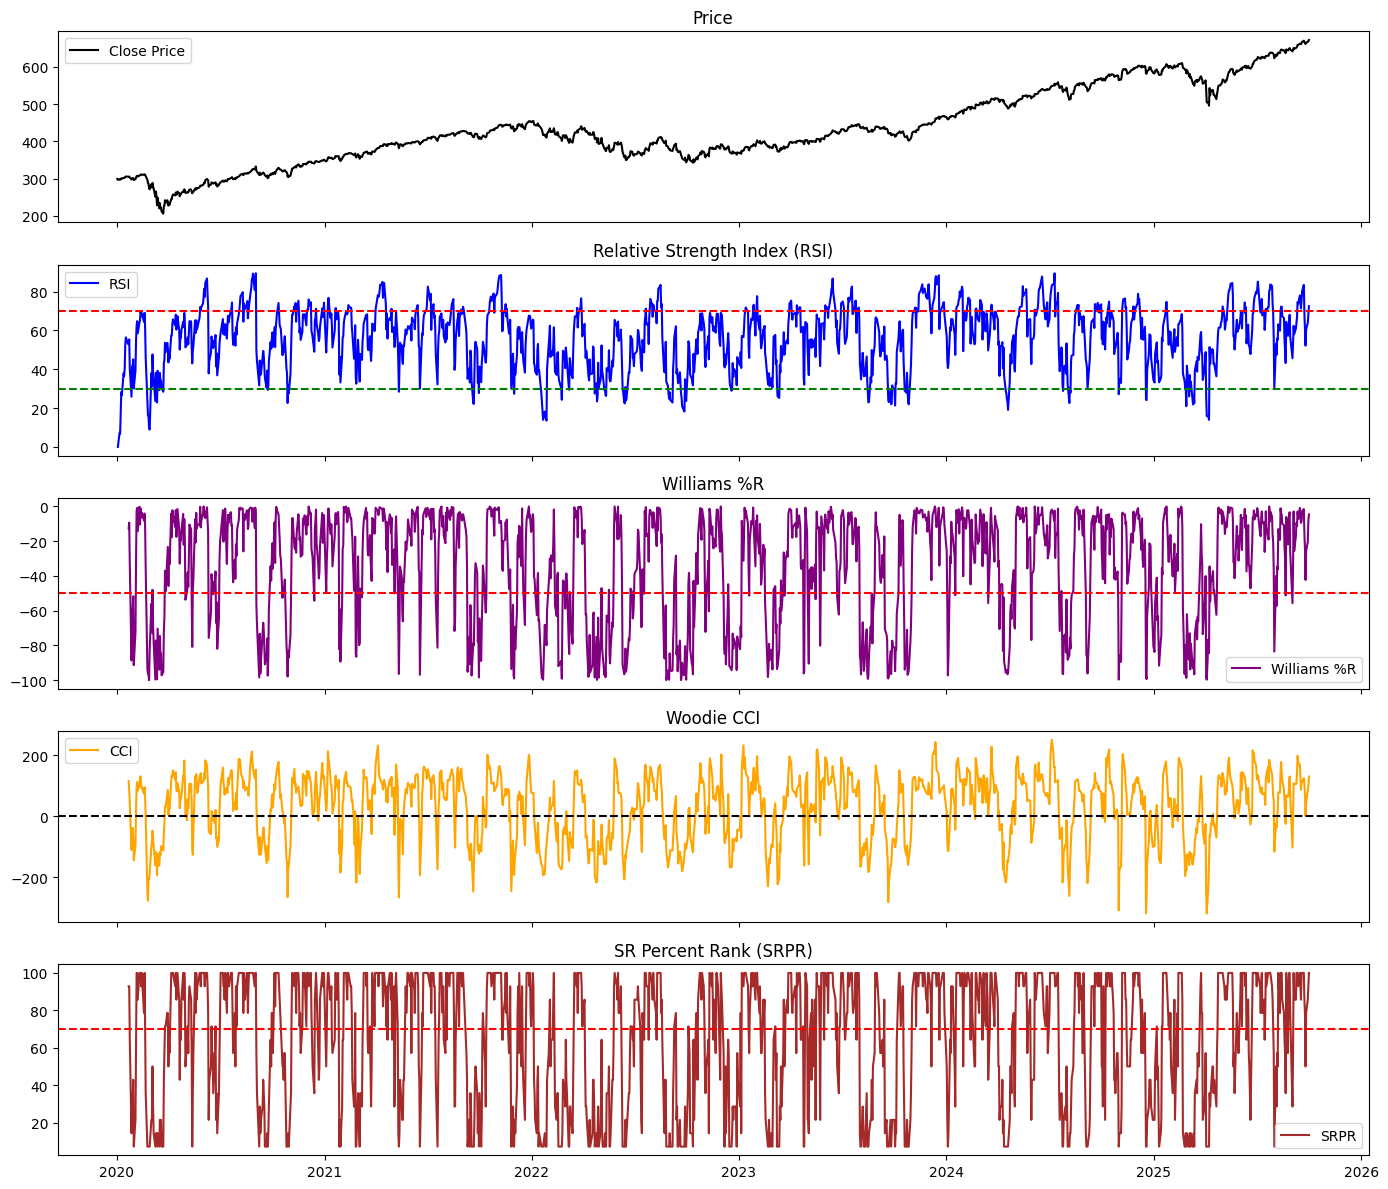

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Parameters
# -------------------------
RSI_OVERBOUGHT_LEVEL = 70
RSI_OVERSOLD_LEVEL = 30
RSI_PERIOD = 14
RSI_SHIFT = 5
RSI_SHIFT_2 = 10
SR_LEVEL = 70
SR_PERIOD = 14
SR_X_BARS = 5
WOODIE_CCI_PERIOD = 14
WOODIE_FAST_PERIOD = 6
WOODIE_SHIFT = 5
WOODIE_SLOW_PERIOD = 34
WR_LEVEL = -50
WR_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------
def calculate_srpr(df, period=SR_PERIOD):
    def sr_percent_rank(series, period):
        return series.rolling(period).apply(
            lambda x: pd.Series(x).rank(pct=True).iloc[-1] * 100, raw=False
        )
    df['SRPR'] = sr_percent_rank(df['Close'], period)
    return df

def calculate_woodie_cci(df, period=WOODIE_CCI_PERIOD):
    df = df.copy()
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    df['MeanDev'] = df['TP'].rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df

def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

def calculate_williams_r(df, period=WR_PERIOD):
    highest_high = df['High'].rolling(window=period).max()
    lowest_low = df['Low'].rolling(window=period).min()
    df['Williams_%R'] = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)
    return df

# -------------------------
# Download Data
# -------------------------

symbol = "IVV"
start_date = "2020-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("IVV_clean.csv", index=False)

# -------------------------
# Apply Indicators
# -------------------------
df = calculate_srpr(df)
df = calculate_woodie_cci(df)
df = calculate_rsi(df)
df = calculate_williams_r(df)

# -------------------------
# Plotting
# -------------------------
fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

# Price
axes[0].plot(df.index, df['Close'], label="Close Price", color="black")
axes[0].set_title("Price")
axes[0].legend()

# RSI
axes[1].plot(df.index, df['RSI'], label="RSI", color="blue")
axes[1].axhline(RSI_OVERBOUGHT_LEVEL, color="red", linestyle="--")
axes[1].axhline(RSI_OVERSOLD_LEVEL, color="green", linestyle="--")
axes[1].set_title("Relative Strength Index (RSI)")
axes[1].legend()

# Williams %R
axes[2].plot(df.index, df['Williams_%R'], label="Williams %R", color="purple")
axes[2].axhline(WR_LEVEL, color="red", linestyle="--")
axes[2].set_title("Williams %R")
axes[2].legend()

# Woodie CCI
axes[3].plot(df.index, df['CCI'], label="CCI", color="orange")
axes[3].axhline(0, color="black", linestyle="--")
axes[3].set_title("Woodie CCI")
axes[3].legend()

# SR Percent Rank
axes[4].plot(df.index, df['SRPR'], label="SRPR", color="brown")
axes[4].axhline(SR_LEVEL, color="red", linestyle="--")
axes[4].set_title("SR Percent Rank (SRPR)")
axes[4].legend()

plt.tight_layout()
plt.show()
